In [7]:
import visual_behavior.ophys.mesoscope.crosstalk_unmix as ica

DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [17]:
CACHE = '/media/rd-storage/Z/MesoscopeAnalysis/'
cache_dir = "/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis"
from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
import matplotlib.pyplot as plt

In [15]:
import numpy as np
import sciris as sc

In [27]:
def plot_traces(x1, x1_name, x2, x2_name, roi_id, title, c_x1 = 'red', c_x2='green'):
    plt.figure(figsize=(20, 10))
    plt.rcParams.update({'font.size': 22})
    plt.subplot(211)
    plt.ylim(min(min(x1), min(x2)), max(max(x1), max(x2)))
    plt.plot(x1, c_x1, label=x1_name, alpha = 0.7)
    plt.plot(x2, c_x2, label=x2_name, alpha = 0.7)
    plt.title(f'{title} for cell {roi_id}', fontsize=18)
    plt.legend(loc='best')
    return

In [ ]:
def plot_trace(x1, x1_name, roi_id, title):
    plt.figure(figsize=(20, 5))
    plt.rcParams.update({'font.size': 22})
    plt.plot(x1, 'r-', label=x1_name)
    plt.title(f'{title} for cell {roi_id}', fontsize=18)
    plt.legend(loc='best')
    return

In [56]:
def plot_roi_from_plane(ica_obj, pkey, exp_id, cache_dir, plot_interval = 'all', roi_id = None):
    tkey='roi'
    dataset = VisualBehaviorOphysDataset(exp_id, cache_dir=cache_dir)
    vba_roi_names = dataset.get_cell_specimen_ids()
    dffs_vba = dataset.dff_traces

    traces_raw_sig   = {}
    traces_raw_ct    = {}
    traces_out_sig   = {}
    traces_out_ct    = {}
    crosstalk_before = {}
    crosstalk_after  = {}
    traces_dff_ica   = {}
    traces_dff_vba   = {}

    roi_names           = ica_obj.rois_names[pkey][tkey] 
    roi_names_valid     = ica_obj.rois_names_valid[pkey][tkey]
    roi_names_valid_ct  = ica_obj.rois_names_valid_ct[pkey][tkey]
    raws_sig            = ica_obj.raws[pkey][tkey][0]
    raws_ct             = ica_obj.raws[pkey][tkey][1]
    crosstalks_before   = ica_obj.crosstalk[pkey][tkey][0]
    crosstalks_after    = ica_obj.crosstalk[pkey][tkey][1]
    ica_outs_sig        = ica_obj.outs[pkey][tkey][0]
    ica_outs_ct         = ica_obj.outs[pkey][tkey][1]
    dffs_ct             = ica_obj.dff_ct[pkey]

    assert len(roi_names) == raws_sig.shape[0], f"Raw traces sig not aligned for exp {exp_id}"
    assert len(roi_names) == raws_ct.shape[0], f"Raw traces ct not aligned for exp {exp_id}"
    assert len(roi_names_valid) == ica_outs_ct.shape[0], f"ICA outs ct is not aligned for exp {exp_id}"
    assert len(roi_names_valid) == ica_outs_sig.shape[0], f"ICA outs sig is not aligned for exp {exp_id}"
    assert len(roi_names_valid) == crosstalks_before.shape[0], f"Crosstalk before is not aligned for exp {exp_id}"
    assert len(roi_names_valid) == crosstalks_after.shape[0], f"Crosstalk after is not aligned for exp {exp_id}"
    assert len(roi_names_valid_ct) == len(dffs_ct), f"Filtered Dff traces are not aligned for exp {exp_id}"

    if plot_interval == 'all':
        start = 0
        end = raws_sig.shape[1]
    else:
        start = plot_interval[0]
        end = plot_interval[1]

    i = 0
    for roi in roi_names:
        traces_raw_sig[str(roi)] = raws_sig[i][start:end]
        traces_raw_ct[str(roi)] = raws_ct[i][start:end]
        i += 1

    i = 0 
    for roi in roi_names_valid:
        traces_out_sig[str(roi)] = ica_outs_sig[i][start:end]
        traces_out_ct[str(roi)] = ica_outs_ct[i][start:end]
        crosstalk_before[str(roi)] = crosstalks_before[i]
        crosstalk_after[str(roi)] = crosstalks_after[i]
        i += 1

    i = 0
    for roi in ica_obj.rois_names_valid_ct[pkey][tkey]:
        traces_dff_ica[str(roi)] = ica_obj.dff_ct[pkey][i][start:end]
        i += 1

    i = 0
    for roi in vba_roi_names:
        traces_dff_vba[str(roi)] = dffs_vba[i][start:end]
        i += 1

    vba_roi_names = [str(roi) for roi in vba_roi_names]
    roi_list = [roi for roi in roi_names_valid_ct if roi in vba_roi_names]

    print(f"Found {len(roi_list)} rois that exist in both VBA and ICA datasets for experiment {exp_id}")

    for roi in roi_list:
        if roi_id is None:
            plot_traces(traces_raw_sig[str(roi)], "raw signal", traces_raw_ct[str(roi)], "raw crosstalk", roi, f"{session}/{exp_id}: raw traces, ct_before = {np.round(crosstalk_before[str(roi)])}") 
            plot_traces(traces_out_sig[str(roi)], "out signal", traces_out_ct[str(roi)], "out crosstalk", roi, f"{session}/{exp_id}: ica traces, ct_after = {np.round(crosstalk_after[str(roi)])}")
            plot_traces(traces_dff_ica[str(roi)], "dff_ica", traces_dff_vba[str(roi)], "dff_vba", roi, "dff traces", c_x1 = '-b', c_x2 = '-g')    
        elif roi == str(roi_id): #plot only roi of interest:
            plot_traces(traces_raw_sig[str(roi)], "raw signal", traces_raw_ct[str(roi)], "raw crosstalk", roi, f"{session}/{exp_id}: raw traces, ct_before = {np.round(crosstalk_before[str(roi)])}") 
            plot_traces(traces_out_sig[str(roi)], "out signal", traces_out_ct[str(roi)], "out crosstalk", roi, f"{session}/{exp_id}: ica traces, ct_after = {np.round(crosstalk_after[str(roi)])}")
            plot_traces(traces_dff_ica[str(roi)], "dff_ica", traces_dff_vba[str(roi)], "dff_vba", roi, "dff traces", c_x1 = 'blue', c_x2 = 'black')    
        else:
            continue

In [57]:
def plot_ica_validation(ica_obj, cache_dir, plot_interval = 'all', exp = None, roi_id = None):
    
    for pkey in ica_obj.pkeys:
        # get traces from VBA
        exp_id = ica_obj.exp_ids[pkey]
        if exp is None: # plotting both planes in pair
            # plot both planes
            plot_roi_from_plane(ica_obj, pkey, exp_id, cache_dir, plot_interval = plot_interval, roi_id = roi_id)
        else: 
            # if exp id was provided : only plot rois from this plane
            if exp == exp_id : 
                plot_roi_from_plane(ica_obj, pkey, exp_id, cache_dir, plot_interval = plot_interval, roi_id = roi_id)
    return 

In [63]:
session = 853416532 #850667270 #849304162
exp_id = 853988454 #850517348
roi_id = None

INFO:Found traces in cache, reading from h5 file
INFO:Validation jsons exist, skipping validation
INFO:Validation jsons exist, skipping validation
INFO:Validation jsons exist, skipping validation
INFO:Validation jsons exist, skipping validation
INFO:Debiased ROI traces exist in cache, reading from h5 file
INFO:Unmixed traces exist in cache, reading from h5 file
INFO:Crosstalk validation json exists, skipping
INFO:Crosstalk validation json exists, skipping
INFO:Filtering dff traces for exp: 853988450
INFO:Filtered dff traces for exp: 853988450 exist, reading from h5 file
INFO:Filtering dff traces for exp: 853988454
INFO:Filtered dff traces for exp: 853988454 exist, reading from h5 file


Found 18 rois that exist in both VBA and ICA datasets for experiment 853988454


/home/nataliao/miniconda3/envs/mesoscope/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


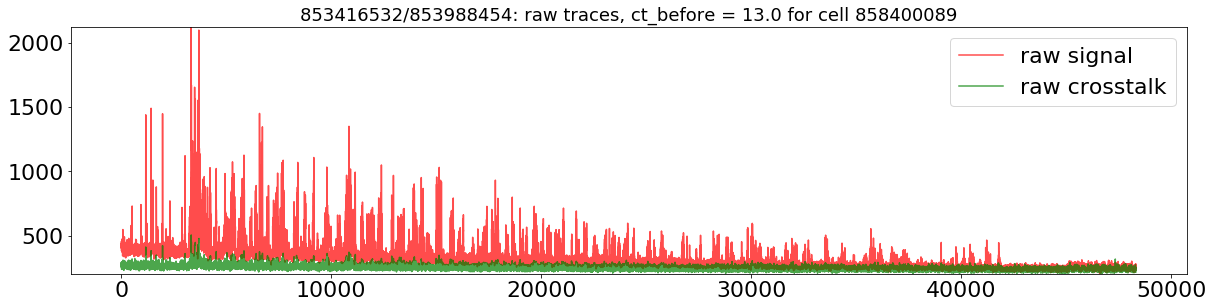

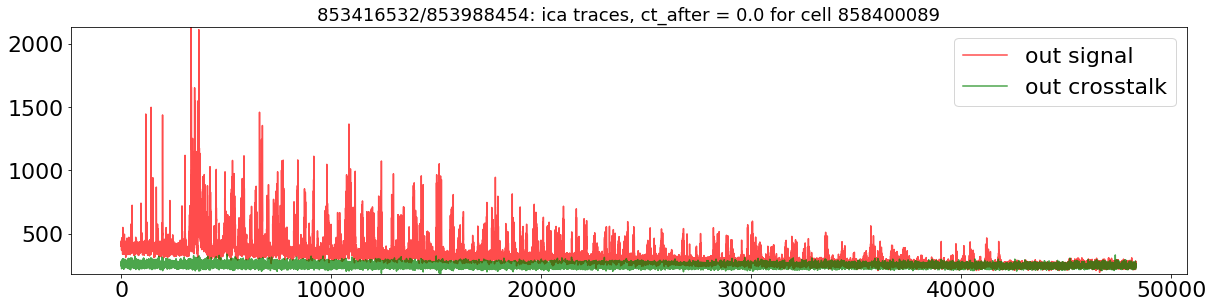

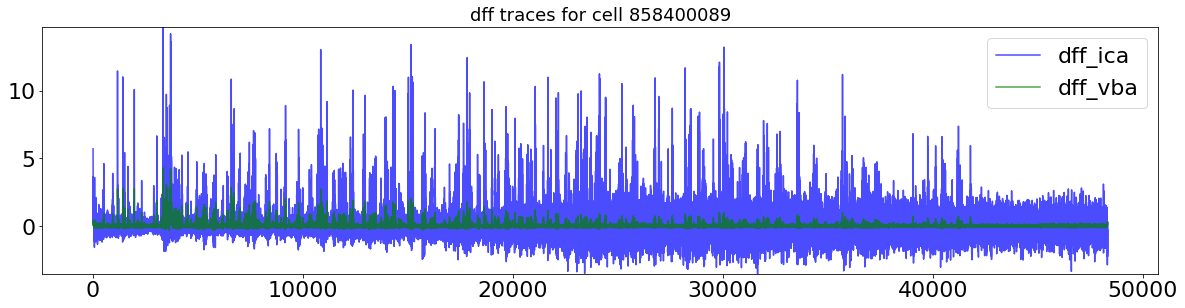

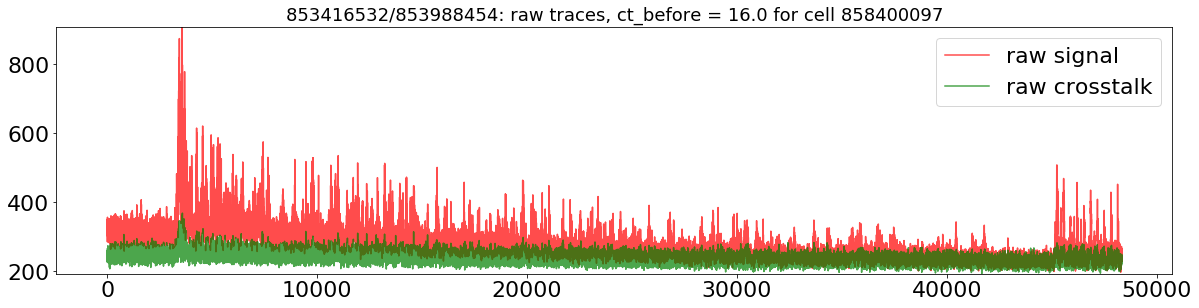

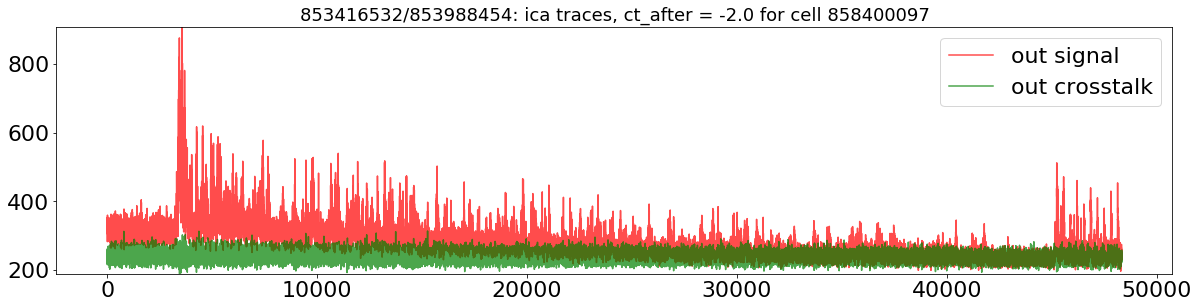

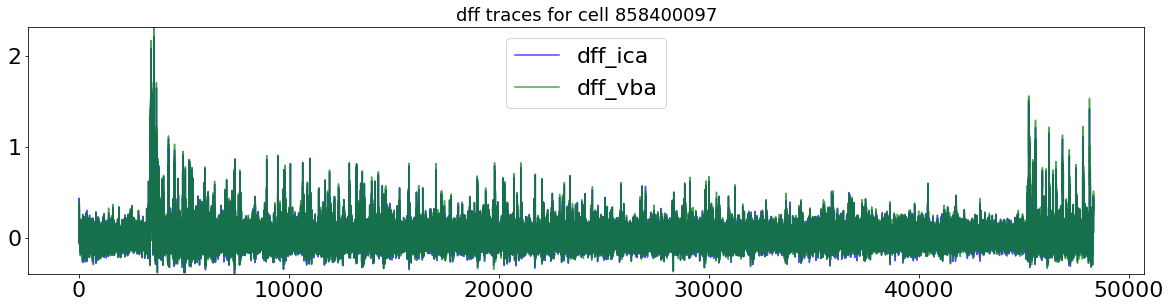

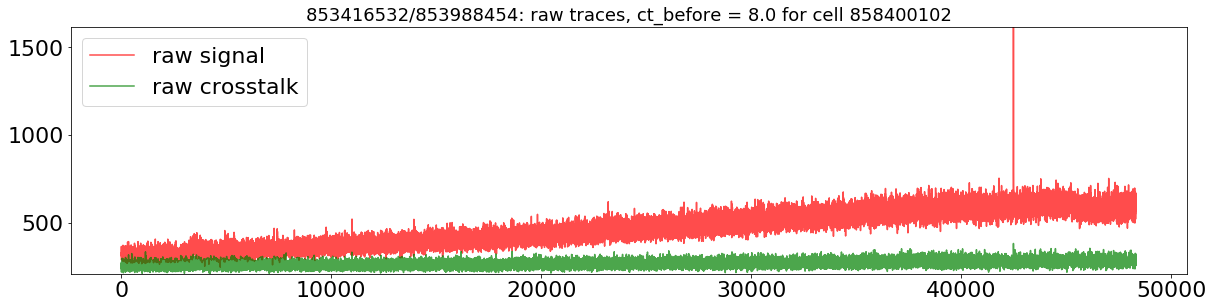

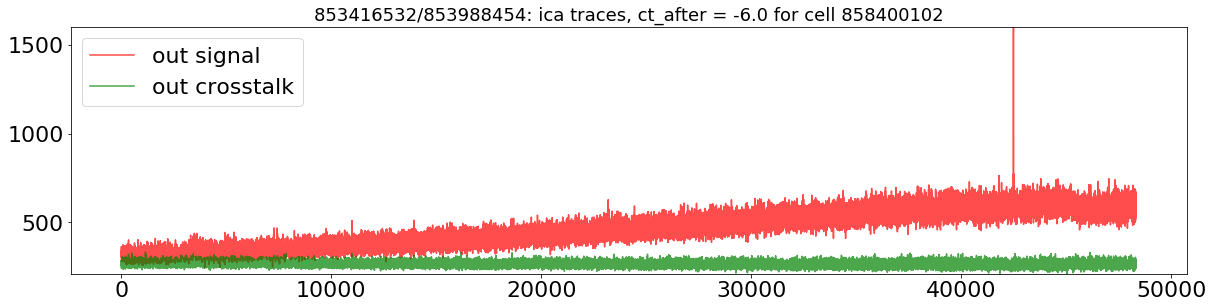

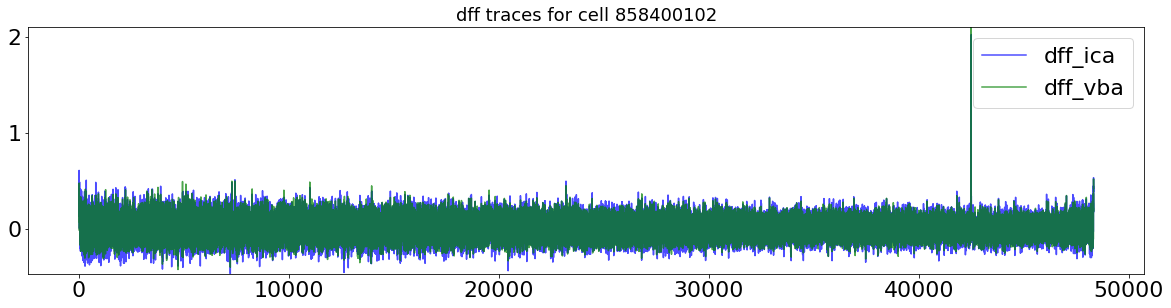

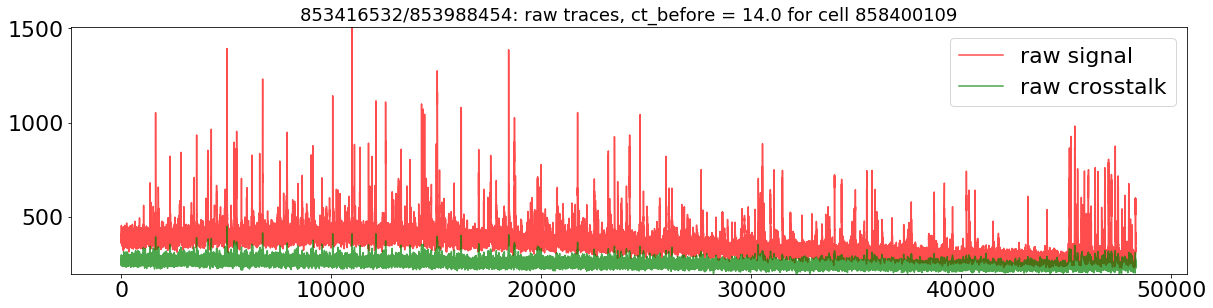

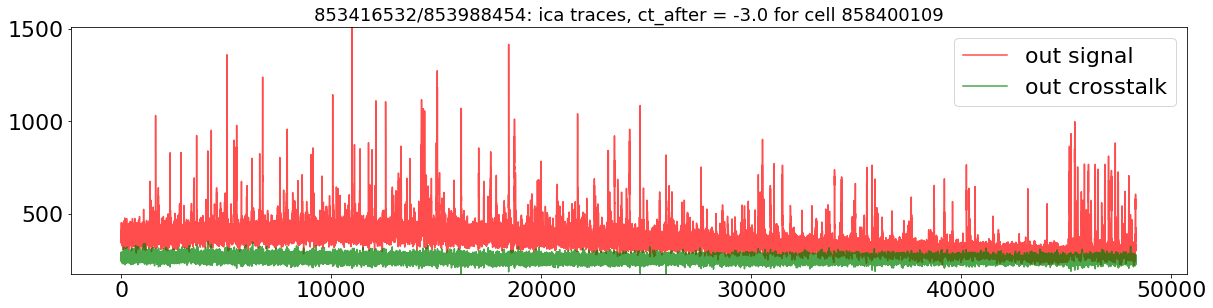

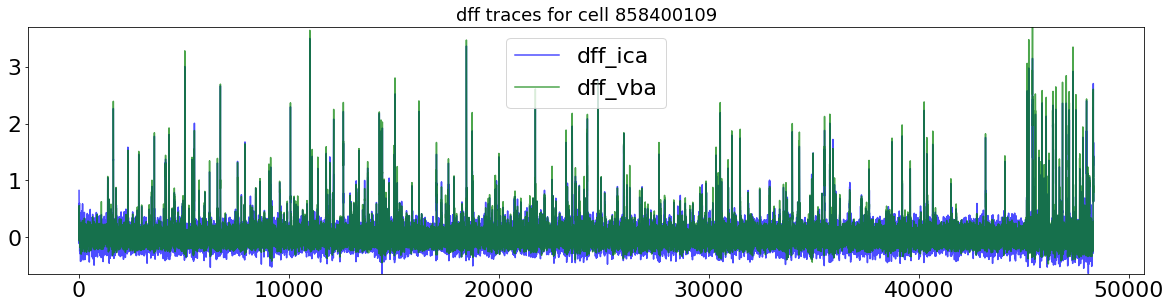

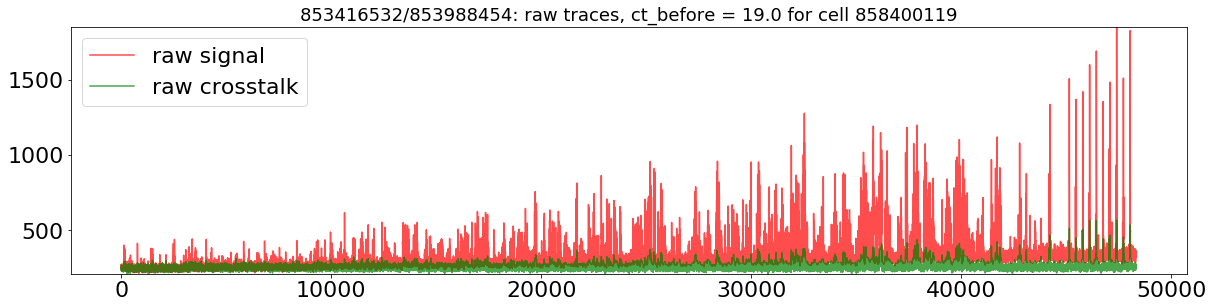

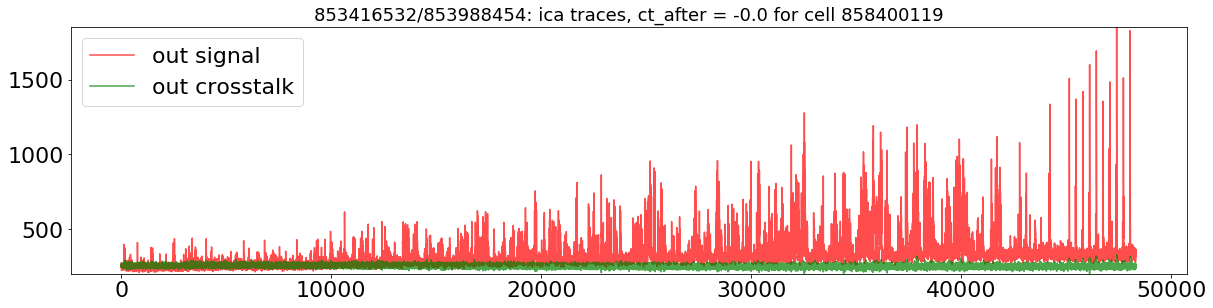

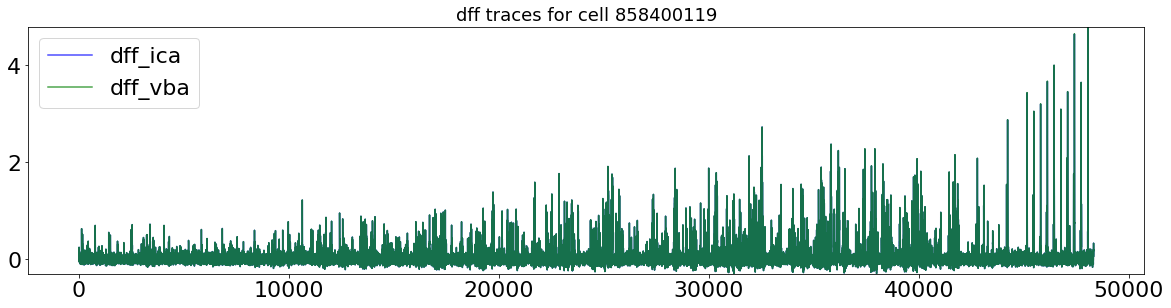

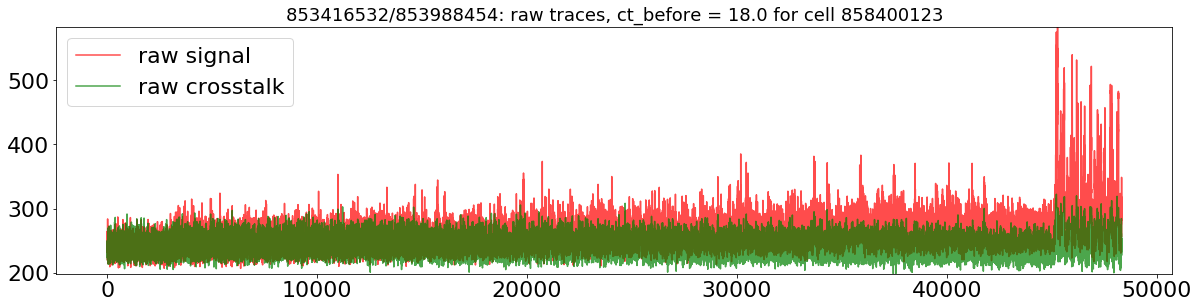

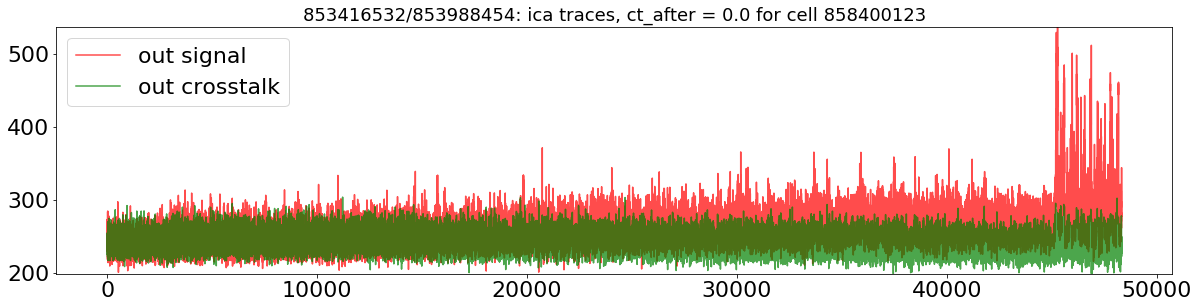

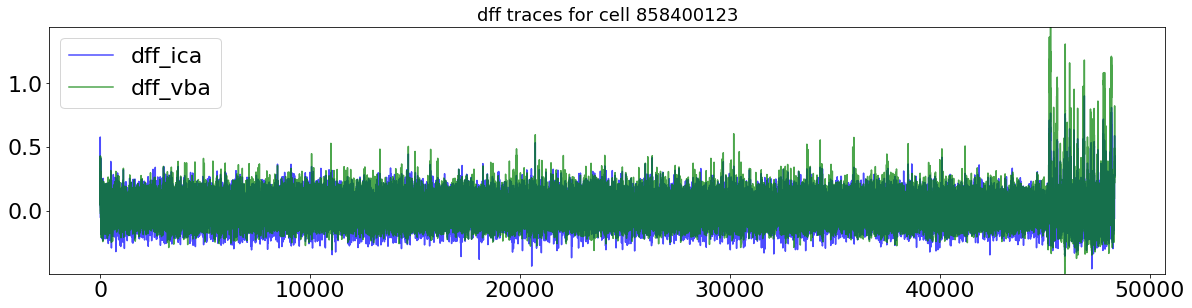

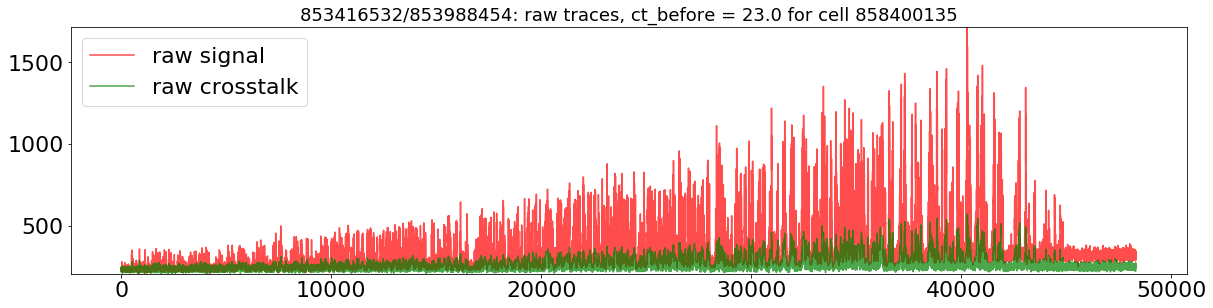

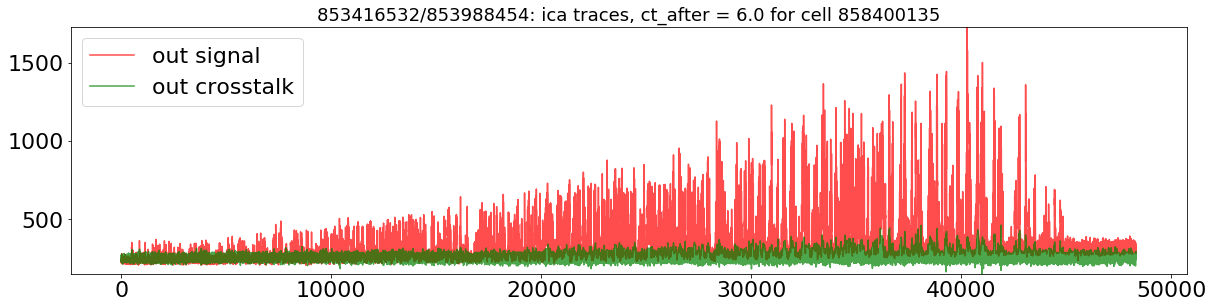

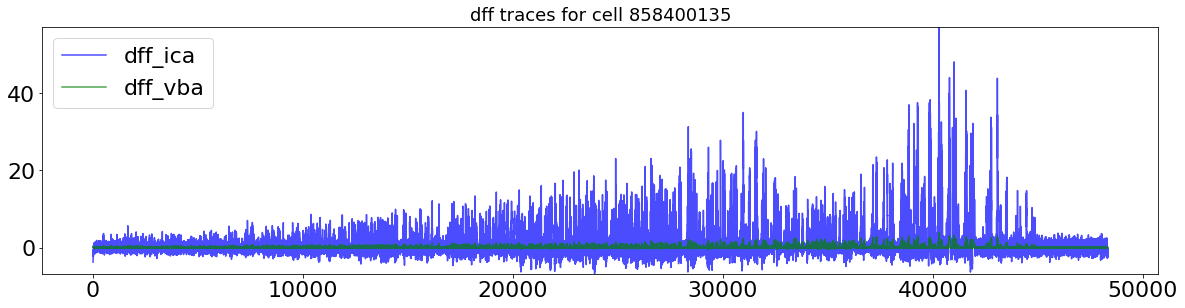

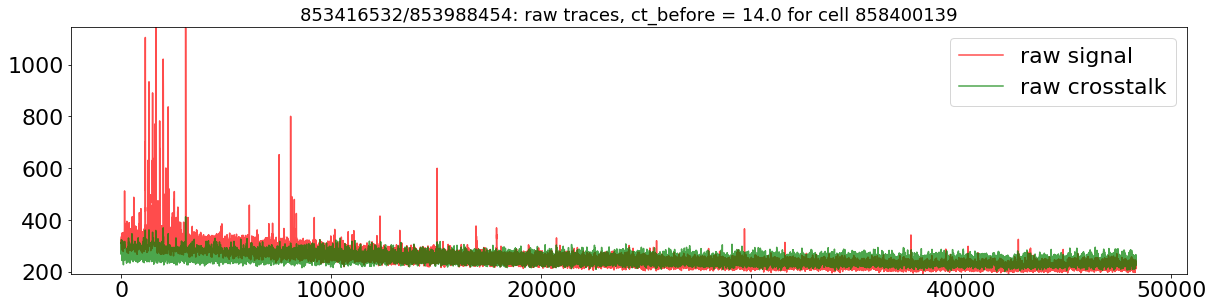

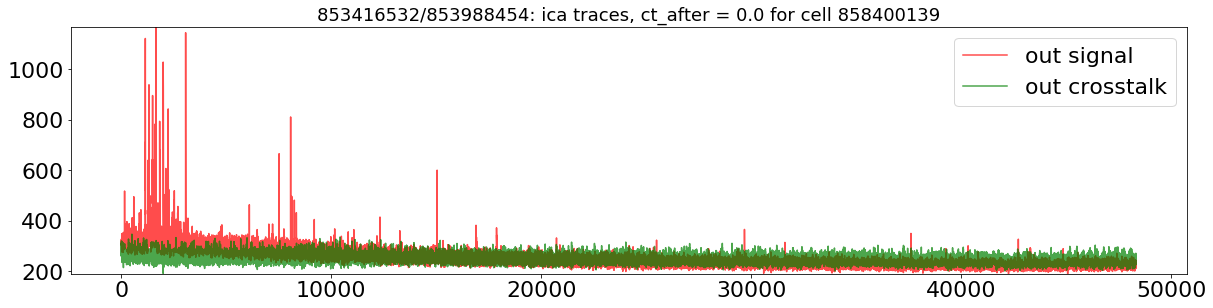

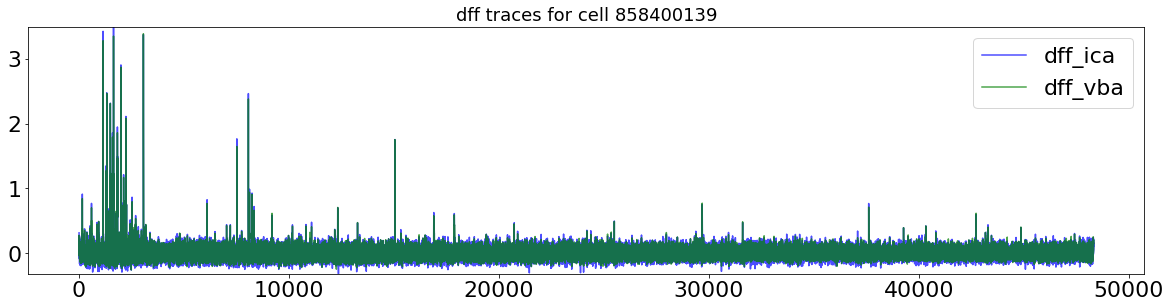

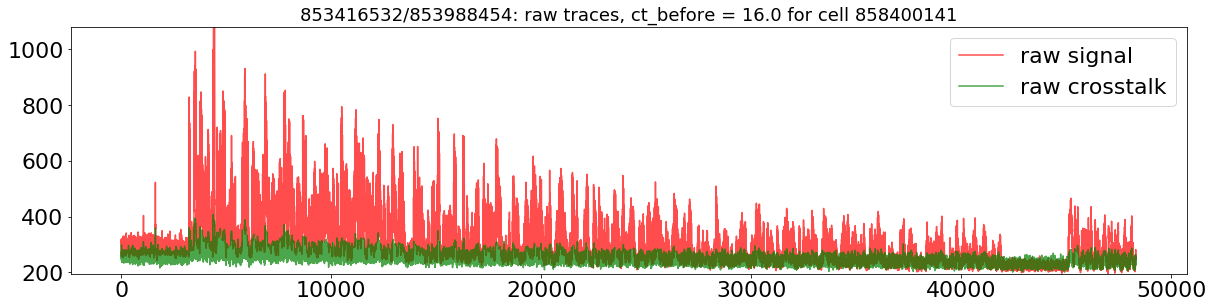

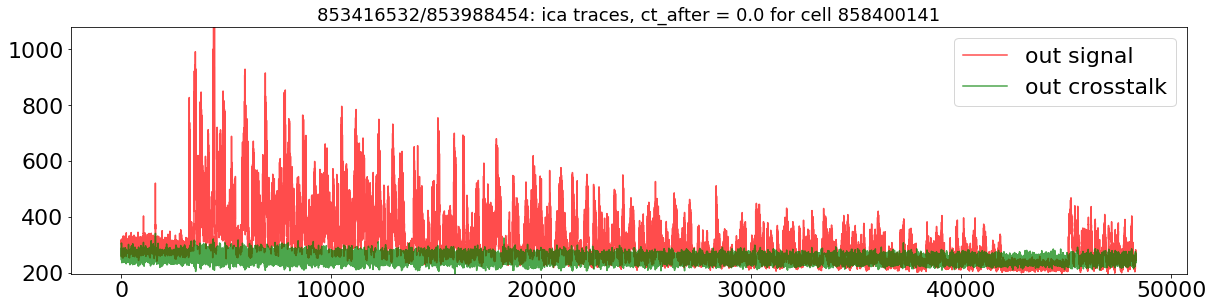

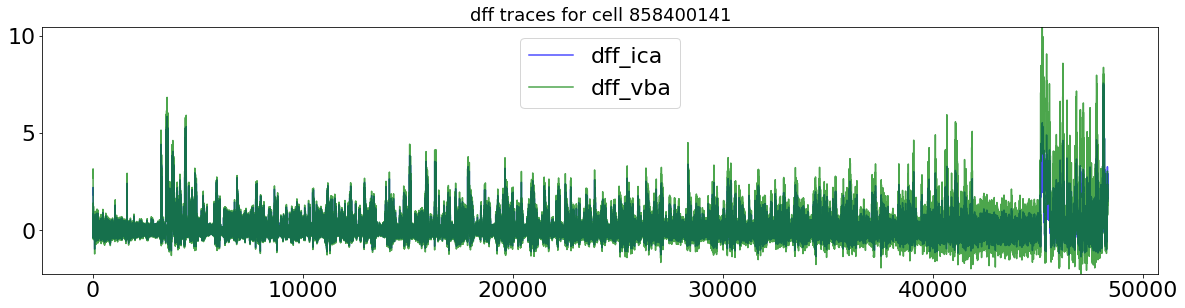

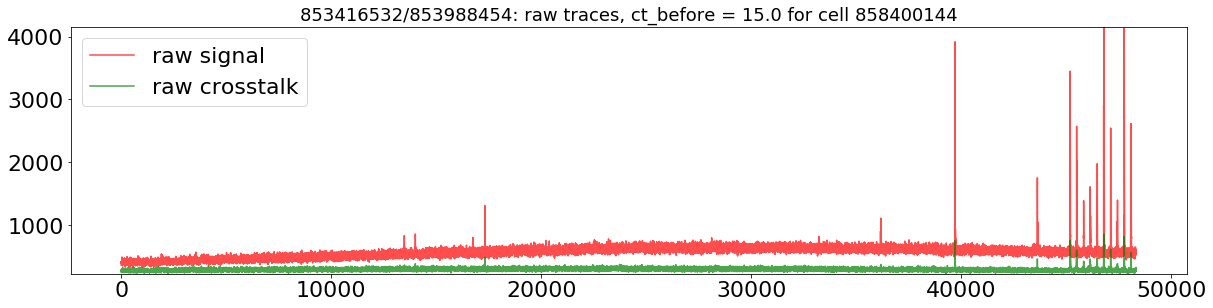

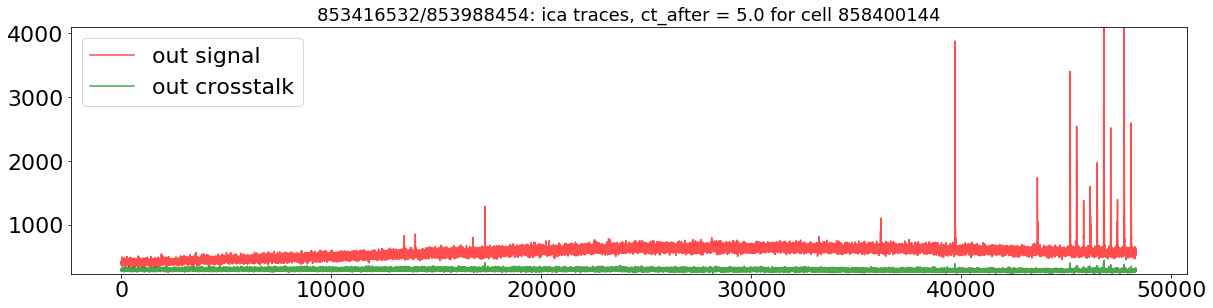

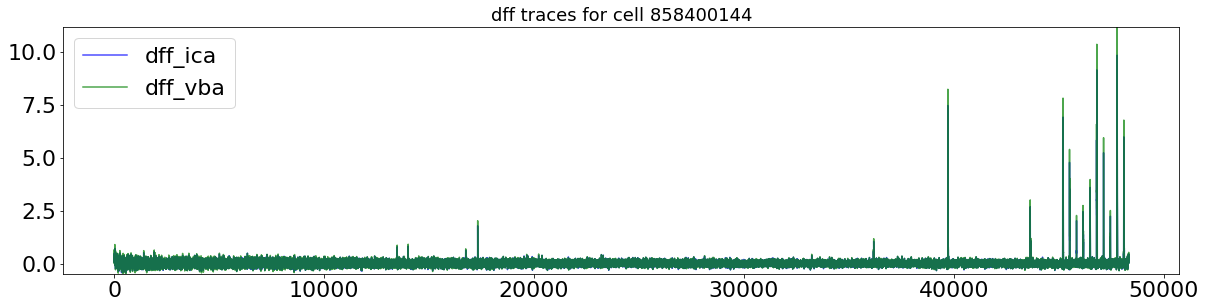

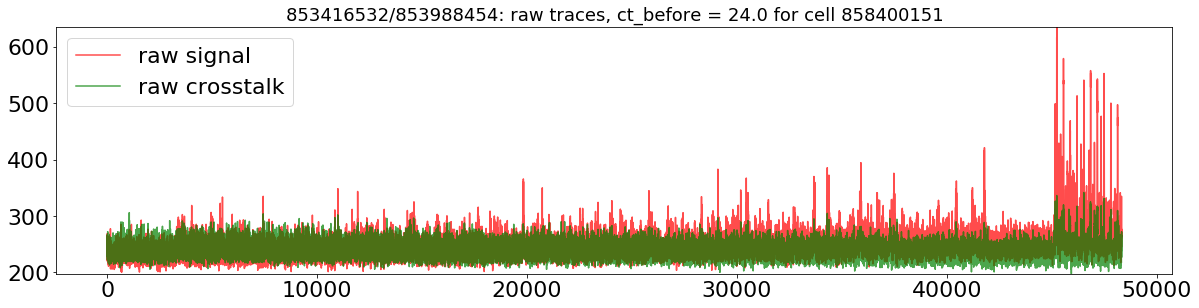

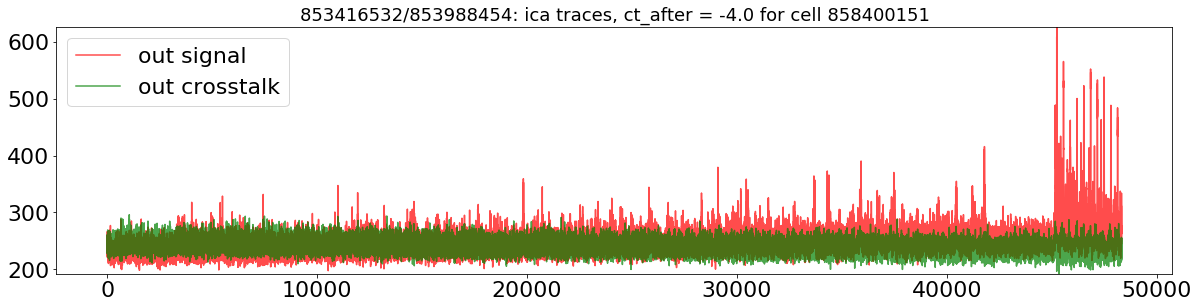

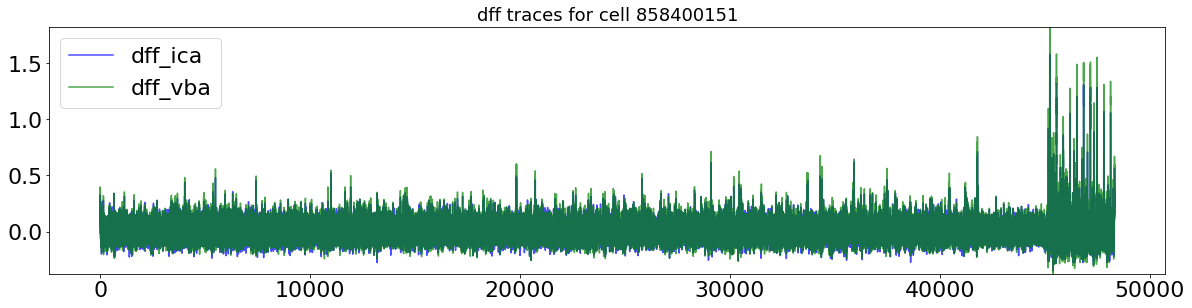

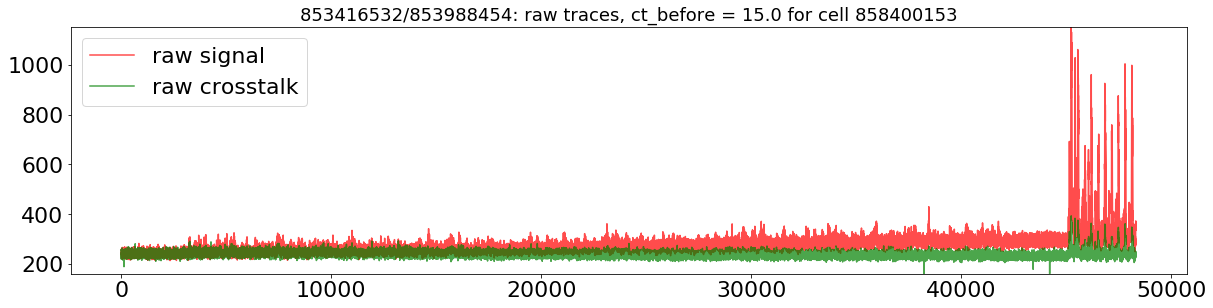

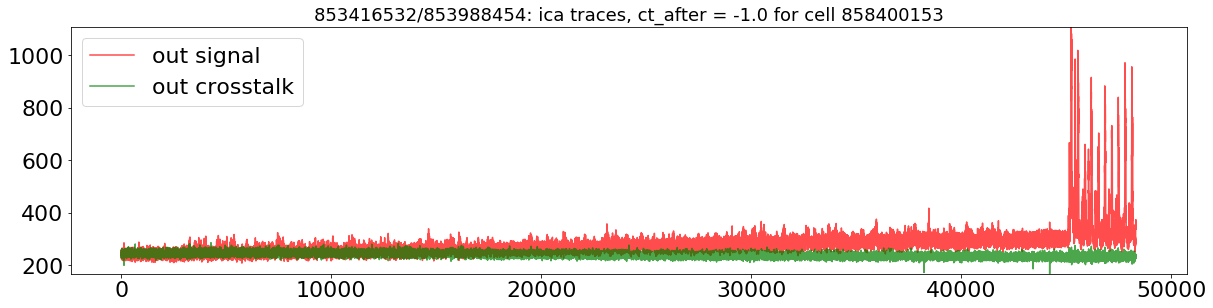

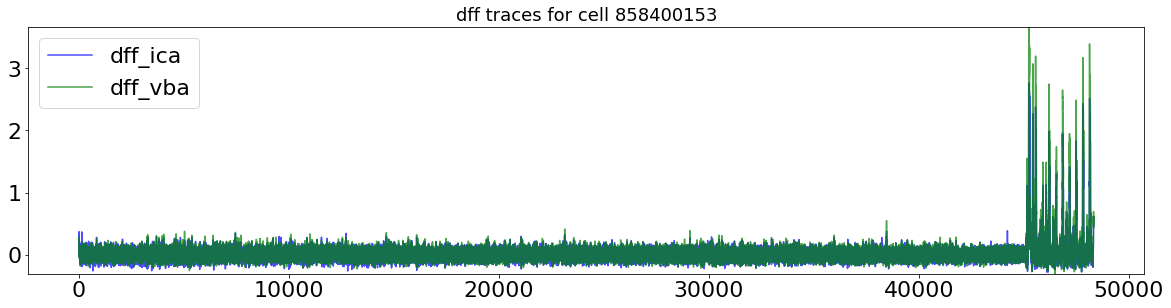

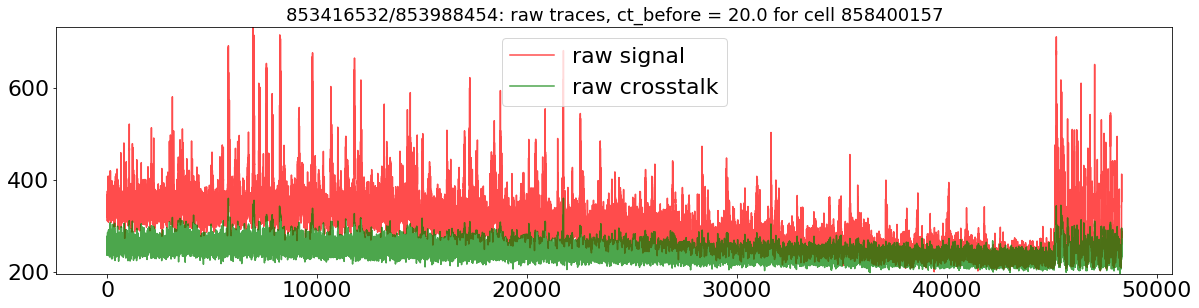

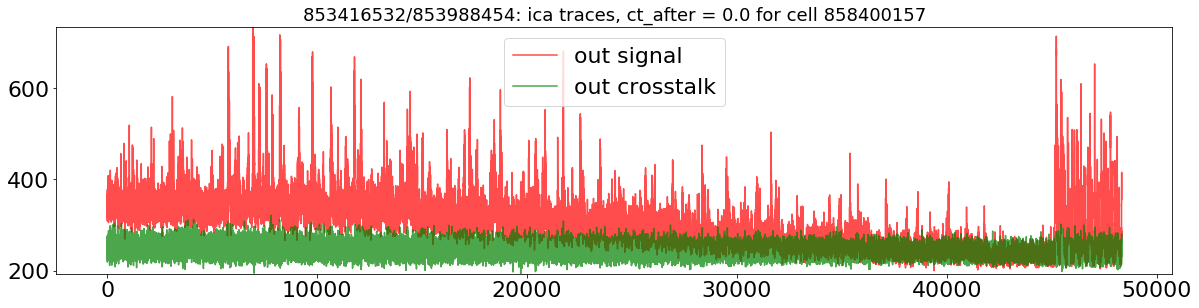

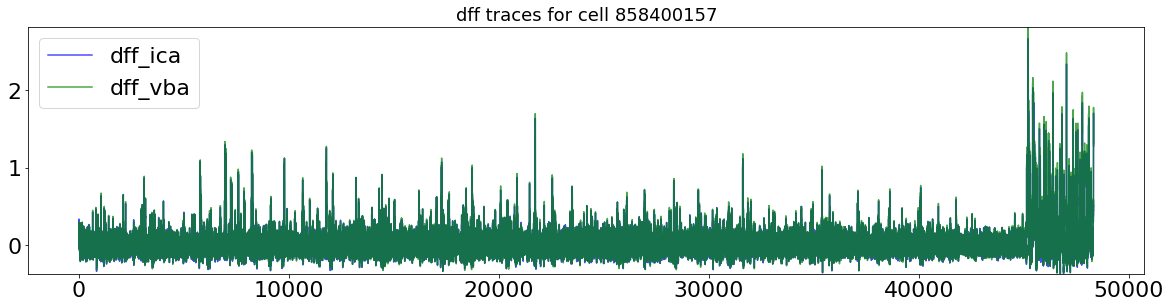

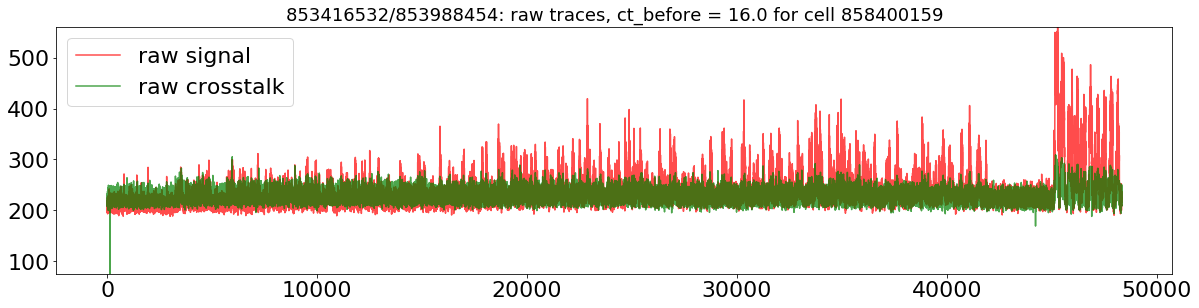

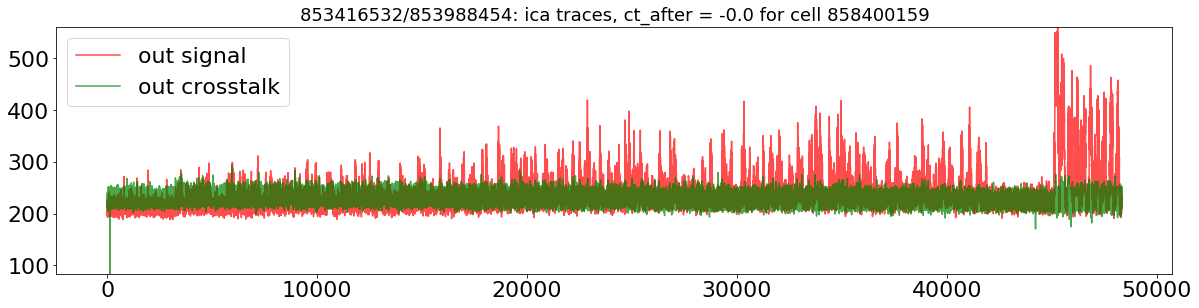

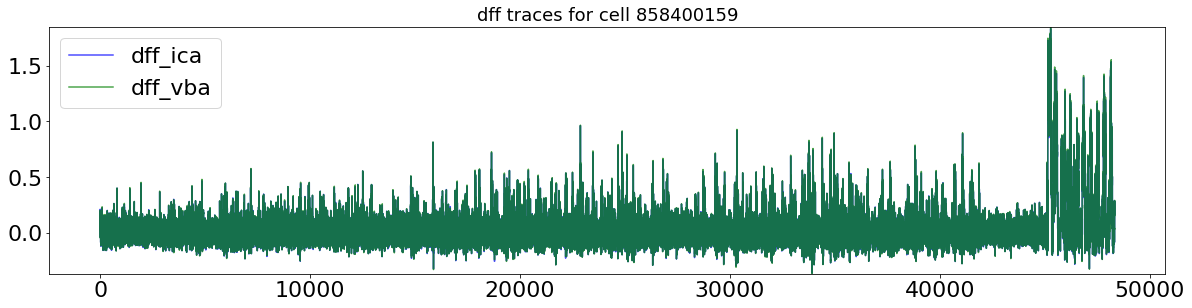

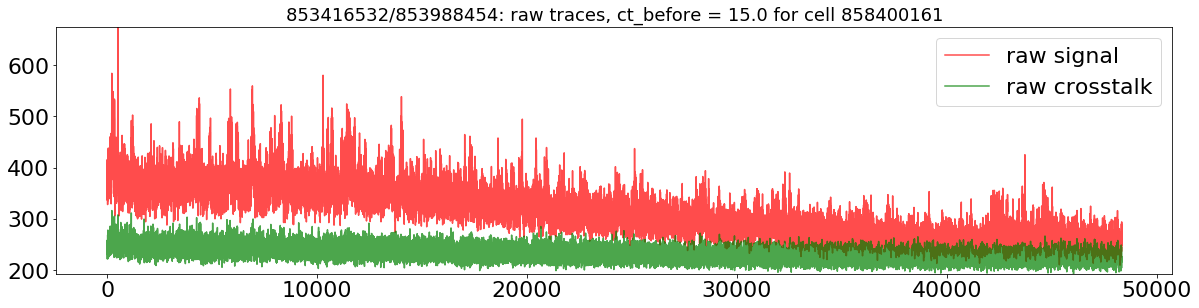

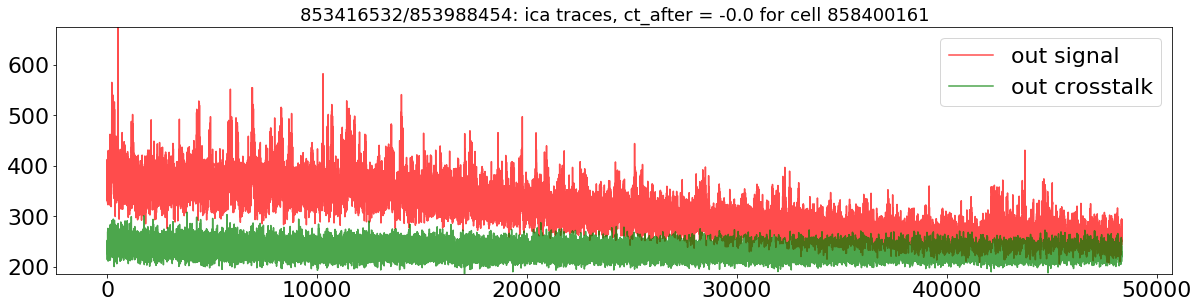

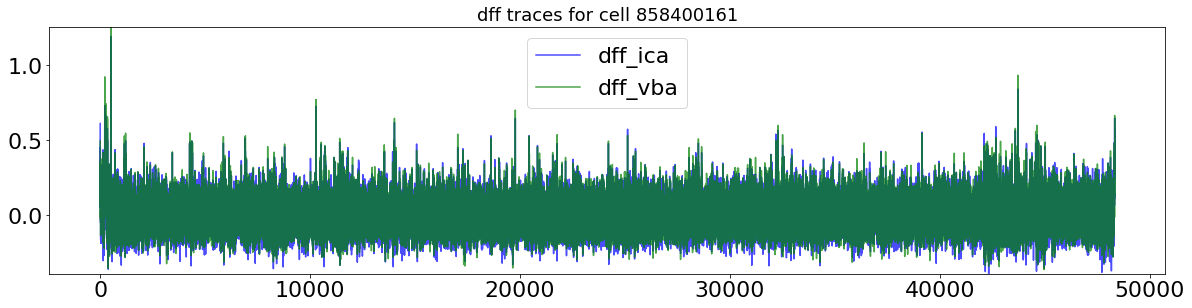

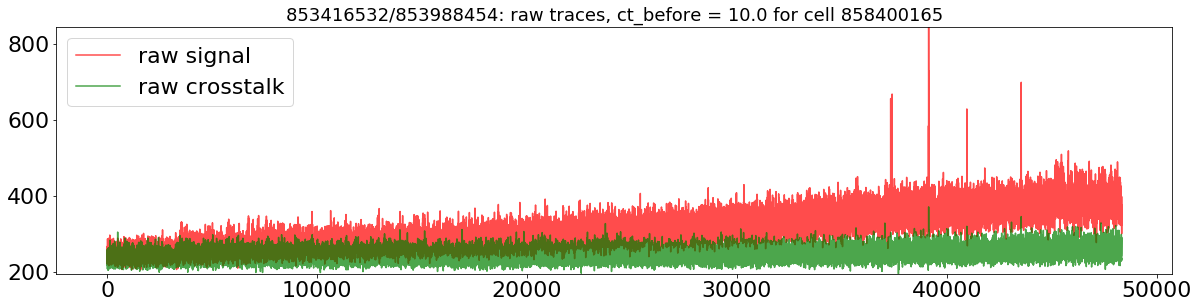

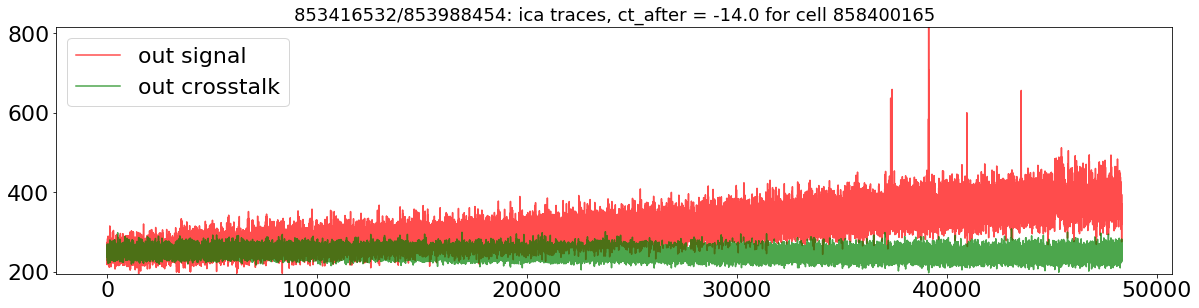

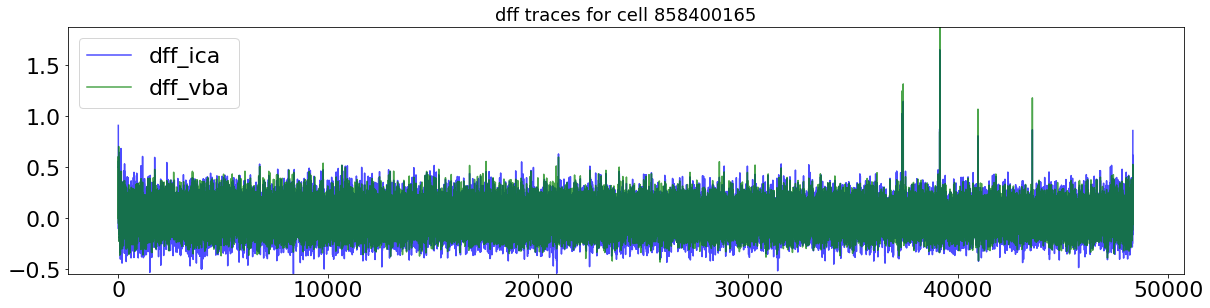

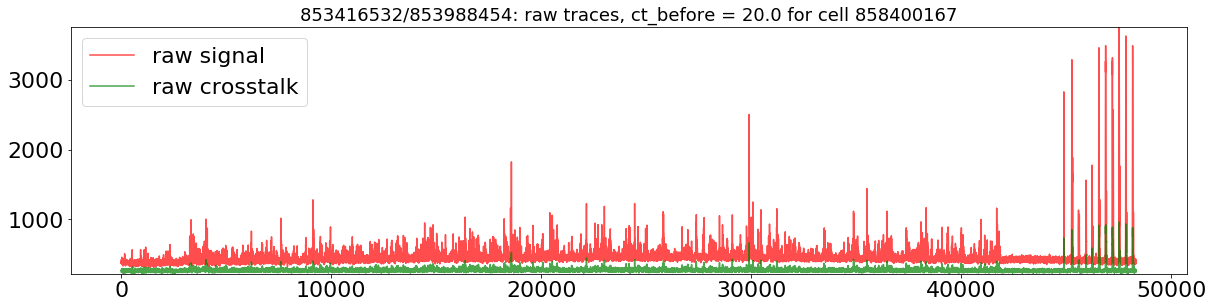

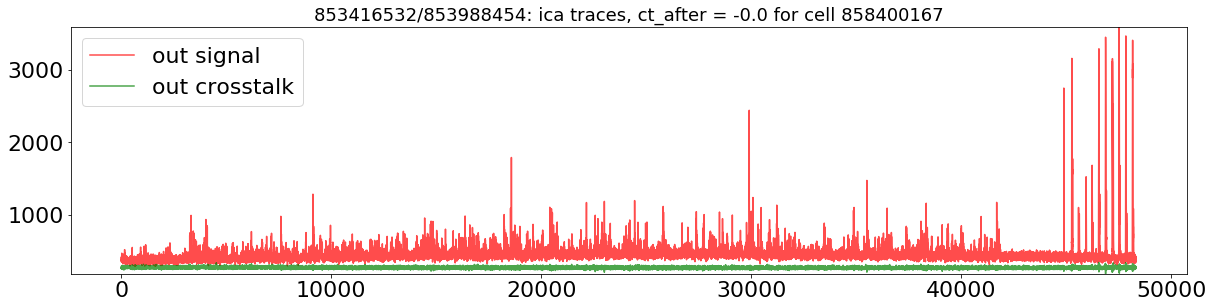

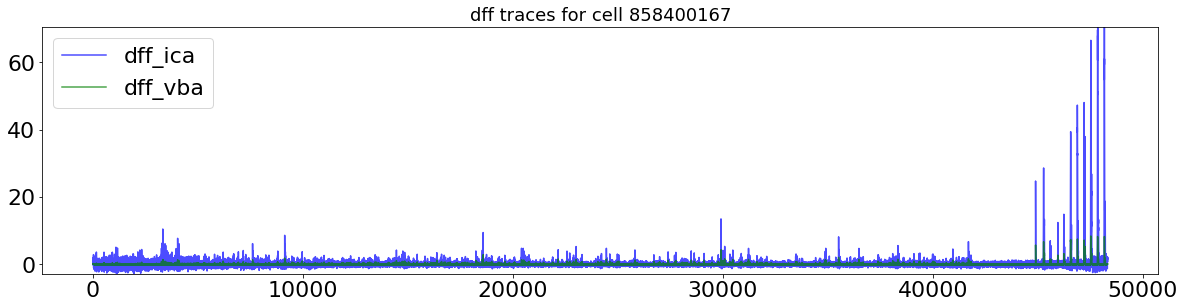

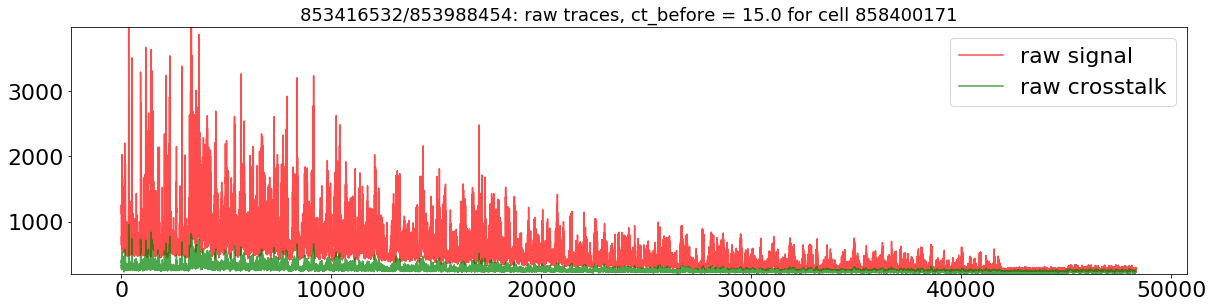

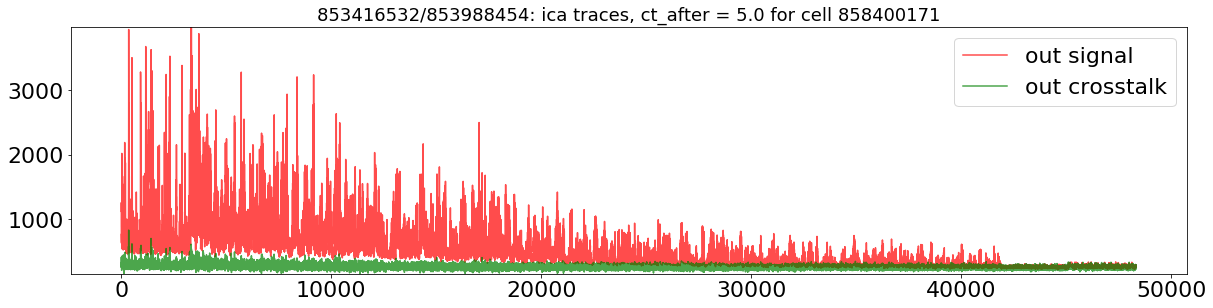

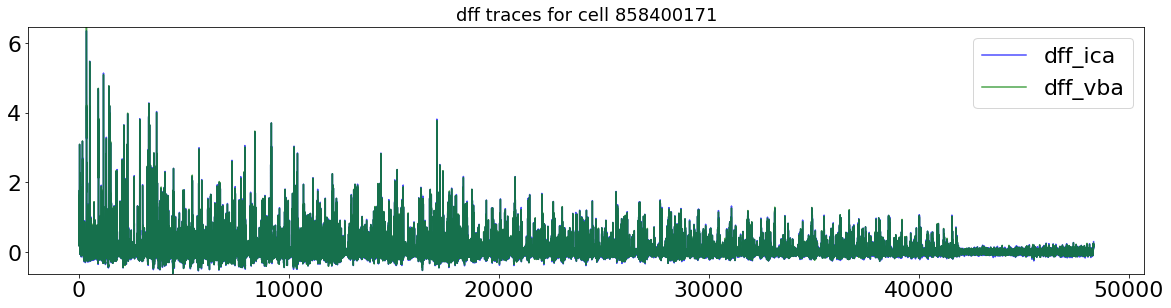

In [64]:
ica_obj = ica.MesoscopeICA(session_id=session, cache=CACHE)
pairs = ica_obj.dataset.get_paired_planes()
for pair in pairs:
    if exp_id in pair:
        ica_obj.set_exp_ids(pair)
        ica_obj.get_ica_traces()
        ica_obj.validate_traces()
        ica_obj.debias_traces()
        ica_obj.unmix_pair()
        ica_obj.validate_cells_crosstalk()
        ica_obj.filter_dff_traces_crosstalk()
        plot_ica_validation(ica_obj, cache_dir, plot_interval = 'all', exp = exp_id, roi_id = roi_id)
    else:
        continue